# Notebook for training yolo detection model

In [28]:
%matplotlib inline

from ultralytics import YOLO
from ultralytics.models.yolo.detect.train import DetectionTrainer
from ultralytics.models.yolo.classify.train import ClassificationTrainer

import pandas as pd
from ultralytics.cfg import cfg2dict, copy_default_cfg
import os
import ultralytics
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

ultralytics.settings.reset()

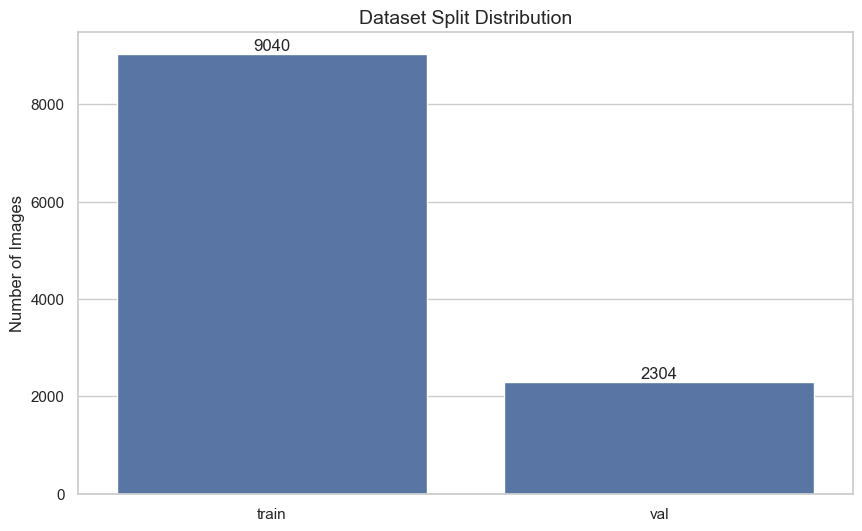

In [29]:
DATA_CONFIG_FILE = "data_config.yaml"
data_config = cfg2dict(DATA_CONFIG_FILE)
ROOT_DIR = data_config["path"]

if not os.path.exists(os.path.join(os.path.join(ROOT_DIR, "autosplit_train.txt"))):
    #autosplit_detect(os.path.join(ROOT_DIR, "images"), (0.8, 0.2, 0))
    pass
    
train_path = os.path.join(ROOT_DIR, "autosplit_train.txt")
val_path = os.path.join(ROOT_DIR, "autosplit_val.txt")

train_lines = []
val_lines = []

if os.path.exists(train_path) and os.path.exists(val_path):
    plt.figure(figsize=(10,6))
    with open(train_path, 'r') as f:
        train_lines = f.readlines()
    with open(val_path, 'r') as f:
        val_lines = f.readlines()

    ax = sns.barplot(
            x=["train", "val"],
            y=[len(train_lines), len(val_lines)],
    )

    plt.title("Dataset Split Distribution")
    ax.bar_label(ax.containers[0])
    plt.ylabel("Number of Images")
    plt.show()

else:
    print("Dataset split files (autosplit_train.txt or autosplit_val.txt) not found. Autosplit may have failed or not been run.")


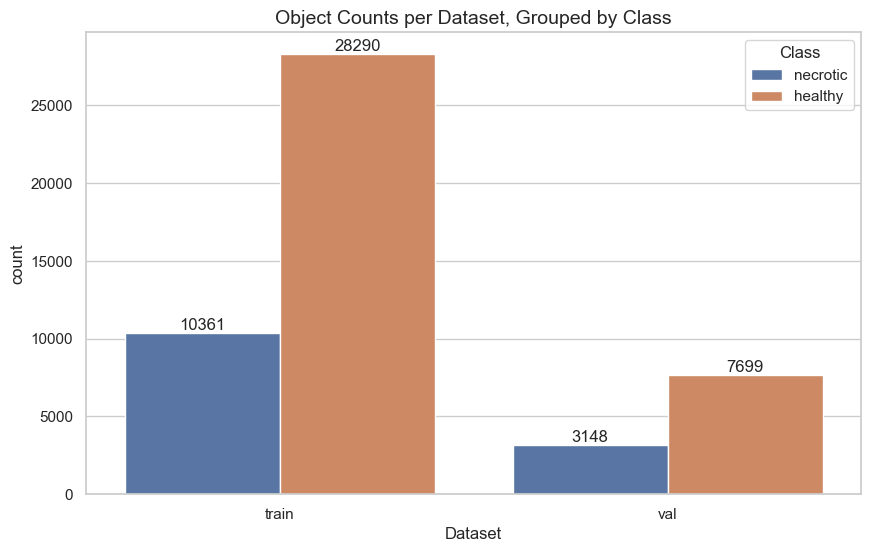

In [30]:

def collect_object_data(root_dir, data):
    """Collects object data (dataset, class) from label files."""
    
    object_data = []
    
    for dataset_name, file_list in data.items():
        if dataset_name in ["names"]: #skip names.
            continue
        for entry in file_list:
            label_filename = os.path.splitext(os.path.basename(entry))[0] + ".txt"
            label_path = os.path.normpath(os.path.join(root_dir, "labels", label_filename))
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        class_id = line.split()[0]
                        object_data.append({
                            'Dataset': dataset_name,
                            'Class': class_id
                        })
    return object_data

def plot_dataset_class_counts(data, root_dir):
    """Plots a bar chart of class counts per dataset (with hue)."""
    
    object_data = collect_object_data(root_dir, data)
    df = pd.DataFrame(object_data).replace("1", data["names"][1]).replace("2", data["names"][2])
    
    plt.figure()
    ax = sns.countplot(x='Dataset', hue='Class', data=df)
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0: # Avoid displaying 0 values
            ax.text(p.get_x() + p.get_width() / 2., height, f'{int(height)}', 
                    ha='center', va='bottom')
    
    plt.title('Object Counts per Dataset, Grouped by Class')
    plt.show()

# Example usage (assuming data_config and ROOT_DIR are defined):
plot_dataset_class_counts({
    "names": data_config["names"],
    "train": train_lines,
    "val": val_lines,
}, ROOT_DIR)

In [31]:
if not os.path.exists("config.yaml"):
    copy_default_cfg()
    os.rename("default_copy.yaml", "config.yaml")


trainer_args = cfg2dict("config.yaml")
trainer = DetectionTrainer(overrides=trainer_args)

Ultralytics 8.3.102  Python-3.12.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=data_config.yaml, epochs=300, time=None, patience=20, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

Overriding class names with single class.


In [32]:
trainer.train()

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning C:\Users\maksi\Documents\datasets\orobanche_cummana\labels... 5149 images, 3891 backgrounds, 0 corrupt: 100%|██████████| 9040/9040 [00:07<00:00, 1201.45it/s]


train: New cache created: C:\Users\maksi\Documents\datasets\orobanche_cummana\labels.cache


val: Scanning C:\Users\maksi\Documents\datasets\orobanche_cummana\labels... 1324 images, 980 backgrounds, 0 corrupt: 100%|██████████| 2304/2304 [00:02<00:00, 986.98it/s] 


val: New cache created: C:\Users\maksi\Documents\datasets\orobanche_cummana\labels.cache
Plotting labels to c:\Users\maksi\Documents\AleketML\runs\detect\train16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to c:\Users\maksi\Documents\AleketML\runs\detect\train16
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      4.13G      1.846      6.899      1.684         20       1024: 100%|██████████| 1130/1130 [04:42<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.91it/s]


                   all       2304      10847      0.579      0.393      0.427       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      3.75G      1.768      3.716      1.568         27       1024: 100%|██████████| 1130/1130 [04:31<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [01:14<00:00,  1.94it/s]

                   all       2304      10847      0.573      0.437      0.461      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      3.42G      1.822      3.683      1.625          5       1024: 100%|██████████| 1130/1130 [04:25<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:38<00:00,  3.71it/s]

                   all       2304      10847      0.449      0.311      0.331      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      5.21G      1.846      3.907      1.715         94       1024:  46%|████▋     | 524/1130 [05:07<05:56,  1.70it/s]


KeyboardInterrupt: 